In [2]:
import numpy as np
from numba import njit
from numba_stats import norm
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import json

from nested_mc import NestedMonteCarlo, gaussian_cdf

ADD SHORT DESCRIPTION OF METHODS

## Gaussian example

EXPLAIN THE EXAMPLE

In [3]:
sigma_inner = 5
sigma_outer = 1

@njit
def gaussian_simulate_scenario(size):
    return np.random.randn(size) * sigma_outer

@njit
def gaussian_simulate_inner_loss(scenario, size):
    return -scenario + np.random.randn(size) * np.sqrt(sigma_inner)

@njit
def gaussian_inner_std(scenarios):
    return np.ones_like(scenarios) * sigma_inner

threshold_gauss = 2.3263478740408408 # corresponds to loss of 1%
norm.cdf(-threshold_gauss, loc=0, scale=1)

array(0.01)

In [4]:
nested_mc_gauss = NestedMonteCarlo(
    simulate_scenario=gaussian_simulate_scenario,
    simulate_inner_loss=gaussian_simulate_inner_loss,
    loss_threshold=threshold_gauss,
    inner_loss_std=gaussian_inner_std
)

### Sanity check for all algorithms

Optimal values of $n$ and $m$ corresponding to the budget $k = 4 \cdot 10^6$.

In [5]:
n_opt = 4499
m_opt = 889

In [6]:
# optimal uniform
nested_mc_gauss.estimation_uniform(m=m_opt, n=n_opt)

0.010891309179817737

In [7]:
# 1/3:2/3 uniform
nested_mc_gauss.estimation_uniform(m=159, n=25199)

0.01059565855787928

In [13]:
# sequential
nested_mc_gauss.estimation_sequential(m_init=2, m_average=130, n=30860)

61800.0
61900.0
62000.0
62100.0
62200.0
62300.0
62400.0
62500.0
62600.0
62700.0
62800.0
62900.0
63000.0
63100.0
63200.0
63300.0
63400.0
63500.0
63600.0
63700.0
63800.0
63900.0
64000.0
64100.0
64200.0
64300.0
64400.0
64500.0
64600.0
64700.0
64800.0
64900.0
65000.0
65100.0
65200.0
65300.0
65400.0
65500.0
65600.0
65700.0
65800.0
65900.0
66000.0
66100.0
66200.0
66300.0
66400.0
66500.0
66600.0
66700.0
66800.0
66900.0
67000.0
67100.0
67200.0
67300.0
67400.0
67500.0
67600.0
67700.0
67800.0
67900.0
68000.0
68100.0
68200.0
68300.0
68400.0
68500.0
68600.0
68700.0
68800.0
68900.0
69000.0
69100.0
69200.0
69300.0
69400.0
69500.0
69600.0
69700.0
69800.0
69900.0
70000.0
70100.0
70200.0
70300.0
70400.0
70500.0
70600.0
70700.0
70800.0
70900.0
71000.0
71100.0
71200.0
71300.0
71400.0
71500.0
71600.0
71700.0
71800.0
71900.0
72000.0
72100.0
72200.0
72300.0
72400.0
72500.0
72600.0
72700.0
72800.0
72900.0
73000.0
73100.0
73200.0
73300.0
73400.0
73500.0
73600.0
73700.0
73800.0
73900.0
74000.0
74100.0
74200.0


0.009883344134802333

In [9]:
# threshold
nested_mc_gauss.estimation_threshold(error_margin=2, n=n_opt)

0.011335852411647033

In [9]:
# adaptative algorithm
nested_mc_gauss.estimation_adaptive(n_0=500, m_0=2, tau_e=100_000, k=n_opt * m_opt)

1058 2.0 0.096 0.2828786494736129
1058 9.45179584120983 0.014177693761814745 0.12830907437839884
1058 18.90359168241966 0.00945179584120983 0.0715941146066198
1058 28.35538752362949 0.008506616257088847 0.04511734958298743
1058 37.80718336483932 0.00945179584120983 0.03357028936315644
1058 47.25897920604915 0.00945179584120983 0.026602262973987812
1058 56.71077504725898 0.00945179584120983 0.022293763601766922
1058 66.1625708884688 0.00945179584120983 0.018508886606543457
1058 75.61436672967864 0.00945179584120983 0.016141624259635227
1058 85.06616257088847 0.00945179584120983 0.014632345456571785
1058 94.5179584120983 0.010396975425330813 0.01429739471432129
1058 103.96975425330812 0.010396975425330813 0.013506629577883029
1058 113.42155009451795 0.00945179584120983 0.01273370700200445
1058 122.87334593572778 0.00945179584120983 0.012141105514344969
1058 132.3251417769376 0.00945179584120983 0.011782052164440263
1058 141.77693761814746 0.00945179584120983 0.011553874047502079
1074 151

0.009970918155380142

In [16]:
# adaptative algorithm with vol estimation
nested_mc_gauss.estimation_adaptive(n_0=500, m_0=2, tau_e=100_000, k=n_opt * m_opt, estimate_inner_std=True)

100000.0


0.010531354715174725

## Put option example

EXPLAIN THE EXAMPLE

In [8]:
rng = np.random.default_rng(seed=0xBADBADBAD)

S0 = 100
K = 95
T = 0.25
tau = 1 / 52
sigma = 0.2
mu = 0.08
r = 0.03
X0 = 1.669 # by BS qformula

@njit
def put_simulate_scenario(size):
    return S0 * np.exp(
        (mu - 0.5 * sigma**2) * tau + 
         sigma * np.sqrt(tau) * np.random.randn(size)
    )

@njit
def put_simulate_inner_loss(size, scenario):
    S_T = scenario * np.exp(
        (r - 0.5 * sigma**2) * (T - tau) + 
         sigma * np.sqrt(T - tau) * np.random.randn(size)
    )
    return X0 - np.exp(-r * (T - tau)) * np.maximum(0, K - S_T)

@njit
def bs_put(scenario):
    """
    Calculates the value of the put option with expiration T and strike K at t = tau given the scenario S_tau.
    """
    S_tau = scenario
    d1 = (np.log(S_tau / K) + (r + 0.5 * sigma**2) * (T - tau)) / sigma / np.sqrt(T - tau)
    d2 = (np.log(S_tau / K) + (r - 0.5 * sigma**2) * (T - tau)) / sigma / np.sqrt(T - tau)
    return K * np.exp(-r * (T - tau)) * gaussian_cdf(-d2) - S_tau * gaussian_cdf(-d1)

@njit
def bs_inner_vol(scenario):
    """
    Calculates standard deviation for a given scenario S_tau.
    """
    S_tau = scenario
    d1 = (np.log(S_tau / K) + (r + 0.5 * sigma**2) * (T - tau)) / sigma / np.sqrt(T - tau)
    d2 = (np.log(S_tau / K) + (r - 0.5 * sigma**2) * (T - tau)) / sigma / np.sqrt(T - tau)
    second_moment = np.exp(-2 * r * (T - tau)) * K**2 * gaussian_cdf(-d2) - 2 * K * S_tau * np.exp(-r * (T - tau)) * gaussian_cdf(-d1) + \
        S_tau**2 * np.exp(sigma**2 * (T - tau)) * gaussian_cdf(-d2 - 2 * sigma * np.sqrt(T - tau))
    return np.sqrt(second_moment - bs_put(scenario)**2)

@njit
def bs_inner_vol_vect(scenarios):
    return np.array(list(map(bs_inner_vol, scenarios)))

threshold_put = 1.221 # corresponds to loss of 1%

In [9]:
nested_mc_put = NestedMonteCarlo(
    simulate_scenario=put_simulate_scenario,
    simulate_inner_loss=put_simulate_inner_loss,
    loss_threshold=threshold_put,
    inner_loss_std=bs_inner_vol_vect
)

### Sanity check for all algorithms

In [10]:
n_opt = 3143
m_opt = 1273

In [10]:
# optimal uniform
nested_mc_put.estimation_uniform(m=m_opt, n=n_opt)

0.012726694241170856

In [13]:
# 1/3:2/3 uniform
nested_mc_put.estimation_uniform(m=159, n=25199)

0.019445216080003176

In [14]:
# sequential
nested_mc_put.estimation_sequential(m_init=2, m_average=4, n=82301)

164602.0
164603.0
164604.0
164605.0
164606.0
164607.0
164608.0
164609.0
164610.0
164611.0
164612.0
164613.0
164614.0
164615.0
164616.0
164617.0
164618.0
164619.0
164620.0
164621.0
164622.0
164623.0
164624.0
164625.0
164626.0
164627.0
164628.0
164629.0
164630.0
164631.0
164632.0
164633.0
164634.0
164635.0
164636.0
164637.0
164638.0
164639.0
164640.0
164641.0
164642.0
164643.0
164644.0
164645.0
164646.0
164647.0
164648.0
164649.0
164650.0
164651.0
164652.0
164653.0
164654.0
164655.0
164656.0
164657.0
164658.0
164659.0
164660.0
164661.0
164662.0
164663.0
164664.0
164665.0
164666.0
164667.0
164668.0
164669.0
164670.0
164671.0
164672.0
164673.0
164674.0
164675.0
164676.0
164677.0
164678.0
164679.0
164680.0
164681.0
164682.0
164683.0
164684.0
164685.0
164686.0
164687.0
164688.0
164689.0
164690.0
164691.0
164692.0
164693.0
164694.0
164695.0
164696.0
164697.0
164698.0
164699.0
164700.0
164701.0
164702.0
164703.0
164704.0
164705.0
164706.0
164707.0
164708.0
164709.0
164710.0
164711.0
164712.0
1

0.29204991433882943

In [154]:
# threshold
nested_mc_put.estimation_threshold(error_margin=50, n=n_opt)

0.009557679484329852

In [13]:
# adaptative algorithm
nested_mc_put.estimation_adaptive(n_0=500, m_0=2, tau_e=10_000, k=n_opt * m_opt)

1239 2.0 0.526 0.38969110243630956
1239 8.071025020177563 0.09281678773204197 0.17714877369506024
1239 16.142050040355127 0.041969330104923326 0.11388504499487094
1239 24.213075060532688 0.02986279257465698 0.08479898717396012
1239 32.28410008071025 0.022598870056497175 0.06564418551688925
1239 40.35512510088781 0.01694915254237288 0.05061766335938524
1239 48.426150121065376 0.0129136400322841 0.040440564601780575
1239 56.49717514124294 0.0129136400322841 0.03457497902703321
1239 64.5682001614205 0.012106537530266344 0.02900487967661881
1239 72.63922518159806 0.011299435028248588 0.02516363201491101
1239 80.71025020177562 0.009685230024213076 0.021082090228483476
1239 88.7812752219532 0.009685230024213076 0.019251767485850665
1239 96.85230024213075 0.008071025020177562 0.01653122748942064
1239 104.92332526230831 0.008071025020177562 0.014928739207952915
1239 112.99435028248588 0.008071025020177562 0.01358536378454916
1239 121.06537530266344 0.008071025020177562 0.012793645913721062
123

0.01164198565707367

In [14]:
# adaptative algorithm with vol estimation
nested_mc_put.estimation_adaptive(n_0=500, m_0=2, tau_e=100_000, k=n_opt * m_opt, estimate_inner_std=True)

2638 10.0 0.188 0.2552277127810971
2638 37.90750568612585 0.02047005307050796 0.06048308060642767
2638 75.8150113722517 0.013267626990144048 0.02836665092600176
2638 113.72251705837756 0.01061410159211524 0.018475182458604737
2638 151.6300227445034 0.010993176648976498 0.015392964580596365
2638 189.53752843062927 0.011372251705837756 0.014136966846106463
2638 227.44503411675512 0.011751326762699014 0.01356169591336939
3051 265.352539802881 0.011751326762699014 0.012742640054802643
3407 262.2091117666339 0.01245493280891511 0.0134562480857221
3528 264.1620193718814 0.012327560904021134 0.013443620398443925
3877 283.4467120181406 0.012471655328798186 0.01339607276006252
4367 283.7245292752128 0.012896569512509672 0.01372187673203536
4367 274.7881841080833 0.012594458438287154 0.013790846023145509
4585 297.68719945042363 0.012823448591710557 0.013727374752826977
4883 305.3435114503817 0.012431842966194111 0.013260038415788985
5119 307.1882039729674 0.011673151750972763 0.01247603880777635

0.011474521142031081

### Number of inner stage samples 

In [21]:
_, inner_losses_mean_gauss, m_array_gauss = nested_mc_gauss.estimation_sequential(m_init=10, m_average=m_opt, n=n_opt, return_info=True)
_, inner_losses_mean_put, m_array_put = nested_mc_put.estimation_sequential(m_init=10, m_average=m_opt, n=n_opt, return_info=True)

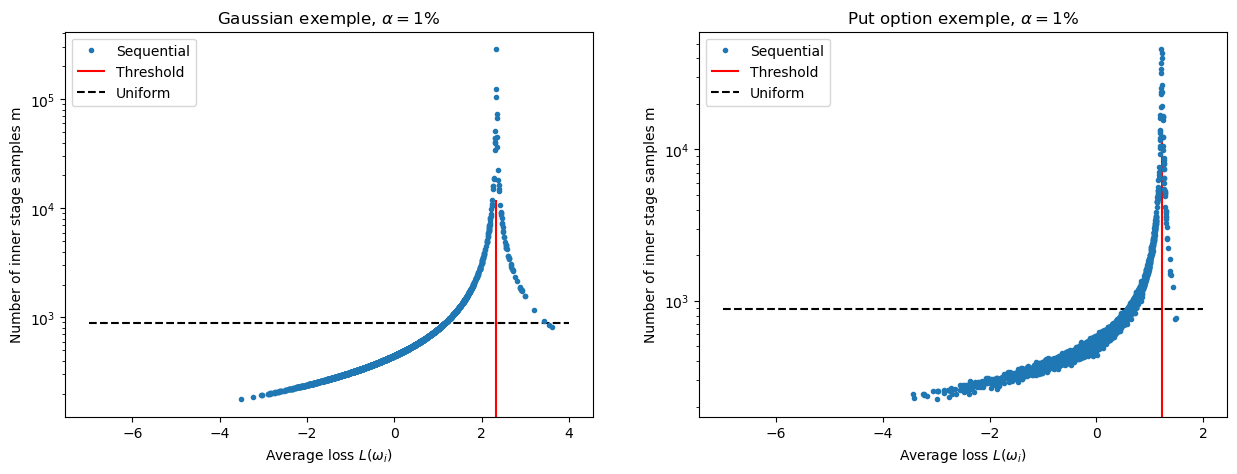

In [28]:
fix, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(inner_losses_mean_gauss, m_array_gauss, '.', label='Sequential')
ax[0].vlines(x=threshold_gauss, ymin=0, ymax=12000, color='r', label='Threshold')
ax[0].hlines(m_opt, -7, 4, color='k', ls='--', label='Uniform')
ax[0].legend()
ax[0].set_title(r'Gaussian exemple, $\alpha = 1\%$')
ax[0].set_xlabel('Average loss $L(\omega_i)$')
ax[0].set_ylabel('Number of inner stage samples m')
ax[0].set_yscale('log')

ax[1].plot(inner_losses_mean_put, m_array_put, '.', label='Sequential')
ax[1].vlines(x=threshold_put, ymin=0, ymax=12000, color='r', label='Threshold')
ax[1].hlines(m_opt, -7, 2, color='k', ls='--', label='Uniform')
ax[1].legend()
ax[1].set_title(r'Put option exemple, $\alpha = 1\%$')
ax[1].set_xlabel('Average loss $L(\omega_i)$')
ax[1].set_ylabel('Number of inner stage samples m')
ax[1].set_yscale('log')

### Calculating statistics for each method

In [14]:
problems = ['gaussian', 'put']
methods_names = ['uniform_optimal', 'uniform_1/3:2/3', 'adaptative', 'adaptative+vol_estim', 'optimal_sequential']
number_of_iters = {
    'gaussian_uniform_optimal': 0,
    'gaussian_uniform_1/3:2/3': 0,
    'gaussian_adaptative': 0,
    'gaussian_adaptative+vol_estim': 0,
    'gaussian_optimal_sequential': 10,
    'put_uniform_optimal': 0,
    'put_uniform_1/3:2/3': 0,
    'put_adaptative': 0,
    'put_adaptative+vol_estim': 0,
    'put_optimal_sequential': 10
}

methods = {
    'gaussian_uniform_optimal': lambda: nested_mc_gauss.estimation_uniform(n=5089, m=786),
    'gaussian_uniform_1/3:2/3': lambda: nested_mc_gauss.estimation_uniform(n=25199, m=159),
    'gaussian_adaptative': lambda: nested_mc_gauss.estimation_adaptive(n_0=500, m_0=2, tau_e=10_000, k=4_000_000),
    'gaussian_adaptative+vol_estim': lambda: nested_mc_gauss.estimation_adaptive(n_0=500, m_0=2, tau_e=10_000, k=4_000_000, estimate_inner_std=True),
    'gaussian_optimal_sequential': lambda: nested_mc_gauss.estimation_sequential(m_init=2, n=30860, m_average=130),
    'put_uniform_optimal': lambda: nested_mc_put.estimation_uniform(n=3143, m=1273),
    'put_uniform_1/3:2/3': lambda: nested_mc_put.estimation_uniform(n=25199, m=159),
    'put_adaptative': lambda: nested_mc_put.estimation_adaptive(n_0=500, m_0=2, tau_e=10_000, k=4_000_000),
    'put_adaptative+vol_estim': lambda: nested_mc_put.estimation_adaptive(n_0=500, m_0=2, tau_e=10_000, k=4_000_000, estimate_inner_std=True),
    'put_optimal_sequential': lambda: nested_mc_put.estimation_sequential(m_init=2, n=19558, m_average=205)
}

with open('stats.json') as json_file:
    stats = json.load(json_file)

In [15]:
for method_name in methods_names:
    for problem in problems:
        print(problem, method_name)
        for _ in tqdm(range(number_of_iters[problem + '_' + method_name])):
            method = methods[problem + '_' + method_name]
            stats[problem][method_name].append(method())

        with open("stats.json", "w") as outfile: 
            json.dump(stats, outfile)

gaussian uniform_optimal


0it [00:00, ?it/s]


put uniform_optimal


0it [00:00, ?it/s]


gaussian uniform_1/3:2/3


0it [00:00, ?it/s]


put uniform_1/3:2/3


0it [00:00, ?it/s]


gaussian adaptative


0it [00:00, ?it/s]


put adaptative


0it [00:00, ?it/s]


gaussian adaptative+vol_estim


0it [00:00, ?it/s]


put adaptative+vol_estim


0it [00:00, ?it/s]


gaussian optimal_sequential


100%|██████████| 10/10 [1:11:22<00:00, 428.26s/it]


put optimal_sequential


100%|██████████| 10/10 [43:44<00:00, 262.50s/it]


### Stats analysis

In [11]:
with open('stats.json') as json_file:
    stats = json.load(json_file)

In [15]:
true_alpha = 0.01

def bias_squared(alphas):
    return (np.mean(alphas) - true_alpha)**2

def mse(alphas):
    return np.mean((np.array(alphas) - true_alpha)**2)

def variance(alphas):
    return np.var(alphas)

In [16]:
results_dfs = {}

for problem in problems:
    data = []
    for method_name in methods_names:
        alphas = stats[problem][method_name]
        data.append([func(alphas) for func in [bias_squared, variance, mse]])

    results_dfs[problem] = pd.DataFrame(data, columns=['Bias squared', 'Variance', 'MSE'], index=methods_names)

In [17]:
results_dfs[problems[0]] # gauss

Bias squared      Variance           MSE
uniform_optimal       2.282883e-08  1.963741e-06  1.986569e-06
uniform_1/3:2/3       1.006678e-06  4.492207e-07  1.455899e-06
adaptative            1.686015e-08  6.616883e-07  6.785484e-07
adaptative+vol_estim  4.930910e-09  7.672919e-07  7.722228e-07
optimal_sequential    2.749557e-09  3.028519e-07  3.056015e-07

In [18]:
results_dfs[problems[1]] # put

Bias squared      Variance           MSE
uniform_optimal       1.109091e-06  3.401587e-06  4.510678e-06
uniform_1/3:2/3       9.150180e-05  7.680689e-07  9.226987e-05
adaptative            3.770370e-08  1.102633e-06  1.140336e-06
adaptative+vol_estim  1.390654e-08  9.816640e-07  9.955705e-07
optimal_sequential    1.918015e-07  5.331615e-07  7.249630e-07

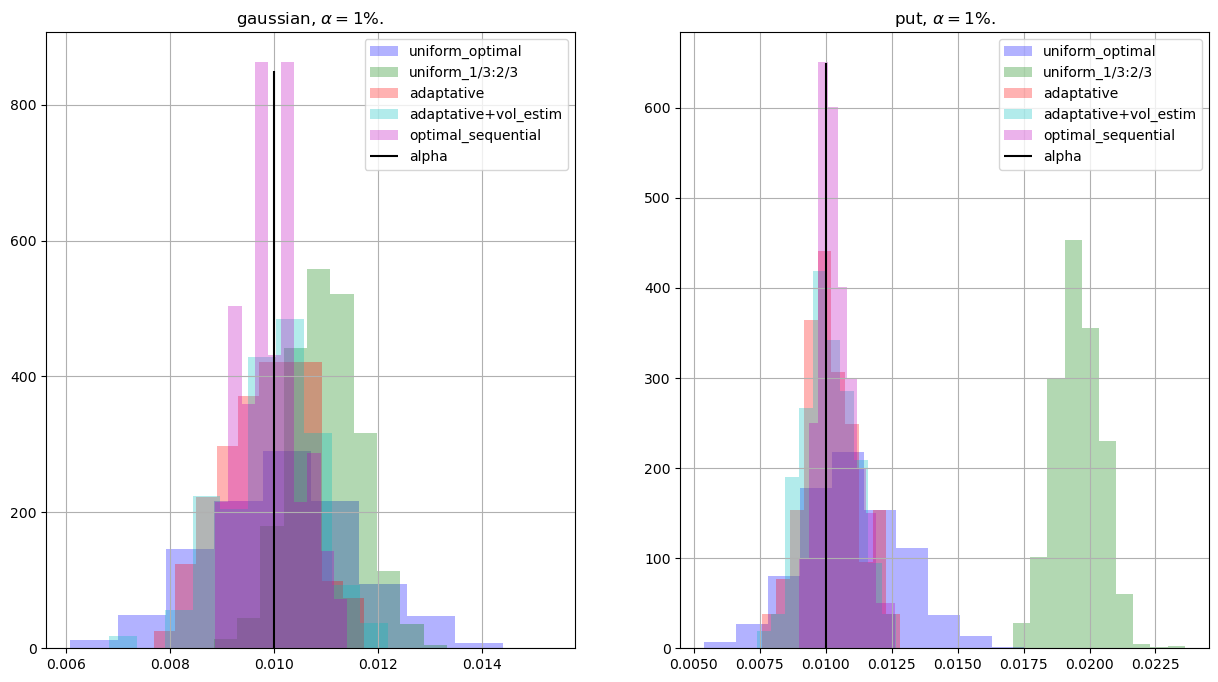

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
colors = ['b', 'g', 'r', 'c', 'm']

for j, method_name in enumerate(methods_names):
    for i, pb in enumerate(problems):
        ax[i].hist(stats[pb][method_name], label=method_name, alpha=0.3, density=True, color=colors[j])
        ax[i].grid()
        ax[i].set_title(pb + r', $\alpha=1\%$.')

ax[0].vlines(0.01, 0, 850, 'k', label='alpha')
ax[1].vlines(0.01, 0, 650, 'k', label='alpha')
ax[0].legend()
ax[1].legend()
plt.show()

### Conclusions

- Sequantial methods are very time-consuming
- ADD CONCLUSIONS